In [1]:
!pip install pyspellchecker
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tqdm.notebook import tqdm
tqdm.pandas()

import re
from spellchecker import SpellChecker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     |████████████████████████████████| 1.9 MB 1.3 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Load data

In [2]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

# Clean data

remove username, urls, etc

In [3]:
def clean(text):
    text = text.fillna("fillna").str.lower()
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

In [4]:
train1["comment_text"] = clean(train1["comment_text"])
train2["comment_text"] = clean(train2["comment_text"])
valid["comment_text"] = clean(valid["comment_text"])
test["content"] = clean(test["content"])

Remove entries with more misspells

In [5]:
spell = SpellChecker()

In [6]:
%%time 
# Counting the number of spelling errors
train1['mispell_count'] = train1['comment_text'].progress_apply(lambda x: len(spell.unknown(x.split())))
train2['mispell_count'] = train2['comment_text'].progress_apply(lambda x: len(spell.unknown(x.split())))


CPU times: user 6min 47s, sys: 2.52 s, total: 6min 50s
Wall time: 6min 47s


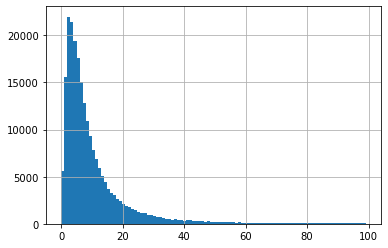

In [7]:
train1[train1['mispell_count'] < 100]['mispell_count'].hist(bins=100)

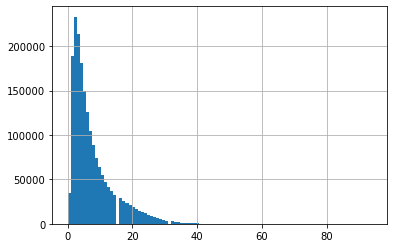

In [8]:
train2[train2['mispell_count'] < 100]['mispell_count'].hist(bins=100)

Check how many toxic comments have more than 20 mispells (Labels are already imbalanced; We do not want to lose them)

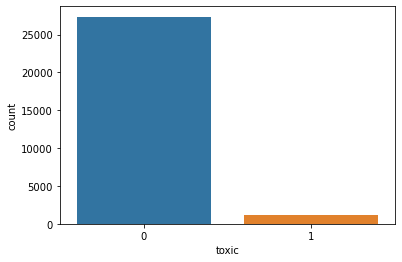

In [9]:
sns.countplot(train1[train1['mispell_count'] >= 20].toxic)

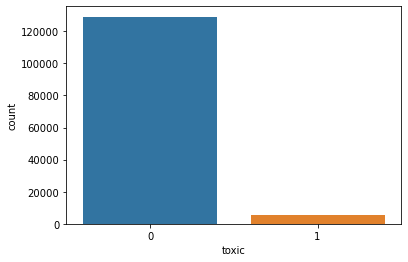

In [10]:
sns.countplot(train2[train2['mispell_count'] >= 20].toxic)

Remove non-toxic comments with more than 20 misspells

In [11]:
train1 = train1.query('toxic==0 & mispell_count < 20 | toxic==1')
train2 = train2.query('toxic==0 & mispell_count < 20 | toxic==1')

**Subsample the data labeled 0 to balance the labeling**

In [12]:
# Examine number of data labeled 1 or 0
print('train2 has %d entries labeled 1' % train2[['comment_text', 'toxic']].query('toxic==1').shape[0])
print('train1 has %d entries labeled 1' % train1[['comment_text', 'toxic']].query('toxic==1').shape[0])
print('train2 has %d entries labeled 0' % train2[['comment_text', 'toxic']].query('toxic==0').shape[0])
print('train1 has %d entries labeled 0' % train1[['comment_text', 'toxic']].query('toxic==0').shape[0])

train2 has 112226 entries labeled 1
train1 has 21384 entries labeled 1
train2 has 1660901 entries labeled 0
train1 has 174798 entries labeled 0


In [13]:
# Combine train1 with a subset of train2 
# (decided to subsample 100,000 samples from train2 labeld 0)
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=0)
])

# Encode data

In [14]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [15]:
# First load the real tokenizer
MODEL = 'jplu/tf-xlm-roberta-large'
# Configuration
MAX_LEN = 192
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [16]:
%%time 

x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

CPU times: user 3min 28s, sys: 956 ms, total: 3min 29s
Wall time: 3min 29s


In [17]:
y_train = train.toxic.values
y_valid = valid.toxic.values

# TPU configs

In [18]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [19]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()
EPOCHS = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Build dataset

In [20]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(len(train))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

# Build model

In [21]:
def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', 
                  metrics=[
                          keras.metrics.TruePositives(name='tp'),
                          keras.metrics.FalsePositives(name='fp'),
                          keras.metrics.TrueNegatives(name='tn'),
                          keras.metrics.FalseNegatives(name='fn'), 
                          keras.metrics.BinaryAccuracy(name='accuracy'),
                          keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall'),
                          keras.metrics.AUC(name='auc')
                  ])

    return model

In [22]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 192, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 559,891,457
Trainable params: 559,891,457
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1min 57s, sys: 32.8 s, total: 2min 30s
Wall time: 2min 32s


# Train model

In [23]:
matplotlib.rcParams['figure.figsize'] = (12, 10)

In [24]:
def plot_metrics(history, val=True):
    metrics =  ['accuracy', 'auc', 'precision', 'recall']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        if val:
            plt.plot(history.epoch, history.history['val_' + metric],
                     color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.ylim([0, 1])

        plt.legend()

In [25]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/2


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:429: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


3190/3190 [==============================] - 1686s 528ms/step - loss: 0.1937 - tp: 116681.0000 - fp: 18721.0000 - tn: 258366.0000 - fn: 14552.0000 - accuracy: 0.9185 - precision: 0.8617 - recall: 0.8891 - auc: 0.9736 - val_loss: 0.3291 - val_tp: 476.0000 - val_fp: 251.0000 - val_tn: 6519.0000 - val_fn: 754.0000 - val_accuracy: 0.8744 - val_precision: 0.6547 - val_recall: 0.3870 - val_auc: 0.8949
Epoch 2/2
3190/3190 [==============================] - 1383s 434ms/step - loss: 0.1494 - tp: 121941.0000 - fp: 14251.0000 - tn: 261613.0000 - fn: 10515.0000 - accuracy: 0.9393 - precision: 0.8954 - recall: 0.9206 - auc: 0.9839 - val_loss: 0.3187 - val_tp: 559.0000 - val_fp: 296.0000 - val_tn: 6474.0000 - val_fn: 671.0000 - val_accuracy: 0.8791 - val_precision: 0.6538 - val_recall: 0.4545 - val_auc: 0.8979


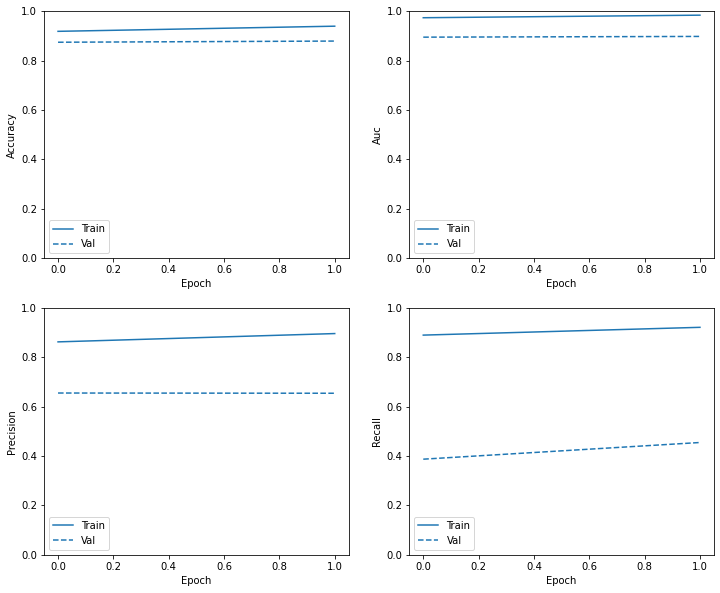

In [26]:
plot_metrics(train_history)

In [27]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS
)

Epoch 1/2
62/62 [==============================] - 27s 431ms/step - loss: 0.2315 - tp: 657.0000 - fp: 249.0000 - tn: 6464.0000 - fn: 566.0000 - accuracy: 0.8973 - precision: 0.7252 - recall: 0.5372 - auc: 0.9262
Epoch 2/2
62/62 [==============================] - 211s 3s/step - loss: 0.1645 - tp: 839.0000 - fp: 200.0000 - tn: 6461.0000 - fn: 372.0000 - accuracy: 0.9273 - precision: 0.8075 - recall: 0.6928 - auc: 0.9653


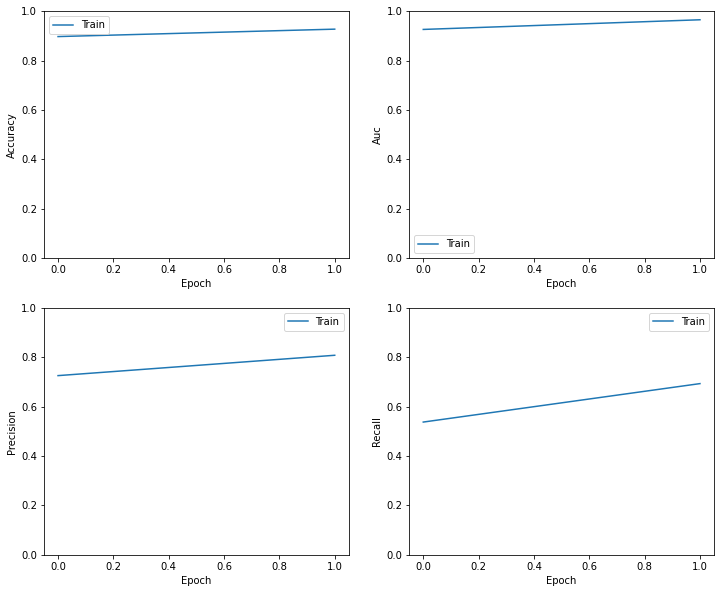

In [28]:
plot_metrics(train_history_2, val=False)

# Predict

In [29]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

499/499 [==============================] - 173s 347ms/step
